In [134]:
import numpy as np
import os
import pandas as pd
from scipy.stats import spearmanr, pearsonr
from scipy.stats import zscore
from scipy.special import logit
import seaborn as sns
from tqdm import tqdm
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from sklearn.neighbors import NearestNeighbors

%run -i '../analysis_utils.py'
%run -i '~/psix/utils/psix_functions.py'
%run -i '~/psix/utils/utils_functions.py'

100%|██████████| 202/202 [00:01<00:00, 144.69it/s]


In [135]:
def downsample_exon(reads_table, mrna_table, exon, cells, downsample_rate = 0.5):
    exon_mrnas = round(mrna_table.loc[exon, cells].fillna(0)).astype(int)
    sub_mrnas = np.random.binomial(exon_mrnas, downsample_rate)
    ratios = [sub_mrnas[i]/exon_mrnas[i] if exon_mrnas[i]>0 else 0 for i in range(len(exon_mrnas))]
    exon_SJ = [x for x in reads_table.index if exon + '_' in x]
    reads_df = pd.DataFrame(np.random.binomial(reads_table.loc[exon_SJ, cells], ratios))
    reads_df.columns = cells
    reads_df.index = exon_SJ
    
    i_sj = reads_df.loc[[exon + '_I1', exon + '_I2']].sum(axis=0)
    e_sj = reads_df.loc[[exon + '_SE']]
    
    psi = i_sj/(2*e_sj + i_sj)
    
    psi.index = [exon]
    
    sub_mrnas_df = pd.DataFrame()
    sub_mrnas_df[exon] = sub_mrnas
    sub_mrnas_df.index = cells
    
    return psi, sub_mrnas_df.T


def downsample_dataset(psi_table, reads_table, mrna_table, exon_list, cells, downsample_rate = 0.5):
    for exon in exon_list:
        psi, sub_mrnas_df = downsample_exon(reads_table, mrna_table, exon, cells, downsample_rate=downsample_rate)
        psi_table.loc[exon, cells] = psi.loc[exon, cells]
        mrna_table.loc[exon, cells] = sub_mrnas_df.loc[exon, cells]
        
    return psi_table, mrna_table, psi, sub_mrnas_df

In [136]:
def make_random(psi_table, mrna_table, read_table, exon):
    data = pd.DataFrame()
    shuffled_cells = shuffle(psi_table.columns)
    data['psi'] = list(psi_table.loc[exon, shuffled_cells])
    data['mrna'] = list(mrna_table.loc[exon, shuffled_cells])
    data['reads'] = list(read_table.loc[exon, shuffled_cells])
    data.index = psi_table.columns
    return data


def make_test(psi_table, mrna_table, read_table, exon_list, rd, seed = 0, randomize_exons = True, all_cells=False, 
              prob = 0.5):
    
    np.random.seed(seed)
    
    if randomize_exons:
        shuffled_cells = shuffle(psi_table.columns)
    else:
        shuffled_cells = psi_table.columns
    
    random_psi = psi_table[shuffled_cells].copy()
    random_mrna = mrna_table[shuffled_cells].copy()
    random_read = read_table[shuffled_cells].copy()
    
    random_psi.columns = psi_table.columns
    random_mrna.columns = psi_table.columns
    random_read.columns = psi_table.columns
    
    all_cell_counts = 0
    
    if all_cells:
        print('all cells')
        random_psi, random_mrna, p, s = downsample_dataset(random_psi, 
                                                   random_read, 
                                             random_mrna, 
                                                   exon_list, psi_table.columns, 
                                             downsample_rate = prob)
        
    else:
        
        print('selecting cells')
        
        for exon in tqdm(exon_list, position=0, leave=True):

            lim_pc_1 = 0
            lim_pc_2 = 0
            coin_2_pc1 = 2
            coin_2_pc2 = 2
            cells_1 = []
            cells_2 = []

            coin_toss_1 = np.random.choice(range(4))
            if (coin_toss_1 == 0) or (coin_toss_1 == 2):
                lim_pc_1 = np.random.uniform(rd.PC_1.quantile(0.3), rd.PC_1.quantile(0.7))
                coin_2_pc1 = np.random.binomial(1, 0.5)

                if coin_2_pc1 == 0:
                    cells_1 = rd.index[rd.PC_1 < lim_pc_1]
                elif coin_2_pc1 == 1:
                    cells_1 = rd.index[rd.PC_1 > lim_pc_1]

            if (coin_toss_1 == 1) or (coin_toss_1 == 2):
                lim_pc_2 = np.random.uniform(rd.PC_2.quantile(0.3), rd.PC_2.quantile(0.7))
                coin_2_pc2 = np.random.binomial(1, 0.5)

                if coin_2_pc2 == 0:
                    cells_2 = rd.index[rd.PC_2 < lim_pc_2]
                elif coin_2_pc2 == 1:
                    cells_2 = rd.index[rd.PC_2 > lim_pc_2]

            if coin_toss_1 == 2:
                cells = [x for x in cells_1 if x in cells_2]

            else:
                cells = list(cells_1) + list(cells_2)

            if len(cells) > 100:    

                random_psi, random_mrna, p, s = downsample_dataset(random_psi, 
                                                       random_read, 
                                                 random_mrna, 
                                                       [exon], cells, 
                                                 downsample_rate = prob)
            else:
                random_psi, random_mrna, p, s = downsample_dataset(random_psi, 
                                                       random_read, 
                                                 random_mrna, 
                                                       [exon], random_psi.columns, 
                                                 downsample_rate = prob)
                
                all_cell_counts += 1

    print(all_cell_counts)    
    return random_psi, random_mrna, shuffled_cells
        
    

In [137]:
import sys
sys.path.append('/mnt/lareaulab/cfbuenabadn/psix/utils/')
import psix_functions as px
%run -i '~/sc_splicing_regulation/utils/utils_functions.py'

In [138]:
tiklova_SJ_reads = pd.read_csv('~/data_sc_regulation/tiklova_extended/SE_counts.tab.gz', sep='\t', index_col=0)
chen_SJ_reads = pd.read_csv('~/data_sc_regulation/chen_extended/SE_counts.tab.gz', sep='\t', index_col=0)
song_SJ_reads = pd.read_csv('~/data_sc_regulation/song/SE_counts.tab', sep='\t', index_col=0)

In [67]:
idx = tiklova_psix.sort_values('L_score').index

In [68]:
random_psi_1, random_mrna_1, shuffled_cells = make_test(tiklova_PSI.loc[idx], 
                                        tiklova_mrna_event.loc[idx], 
                                    tiklova_SJ_reads, idx, tiklova_rd[['PC_1', 'PC_2']], seed=0, prob=0.1)

  0%|          | 0/1988 [00:00<?, ?it/s]

selecting cells


100%|██████████| 1988/1988 [22:07<00:00,  1.50it/s]

519


In [37]:
W_tiklova = px.get_distance_matrix(tiklova_rd, k=100)

  0%|          | 5/1197 [00:00<00:28, 41.20it/s]

Changed to natural log


100%|██████████| 1197/1197 [00:24<00:00, 49.00it/s]


In [46]:
calculate_exon_L(random_psi_1, W_tiklova, random_mrna_1, 'Clta_1', k = 0, c = 0.1,approximate = 10)

0.014138158657405137

In [69]:
r_psi = tiklova_PSI[shuffled_cells].copy()
r_psi.columns = tiklova_PSI.columns
r_mrna = tiklova_mrna_event[shuffled_cells].copy()
r_mrna.columns = tiklova_mrna_event.columns

In [81]:
def elife_test(psi_table, mrna_table, clusters, obs_min, mrna_min = 10, mask_diff = False):
    kw = apply_kruskal_wallis(psi_table, mrna_table, clusters, 
                          obs_min = obs_min, mrna_min=mrna_min, linearize=False)
    
    kw['KW_score'] = kw.KW_score#.fillna(0)
    kw['pvals'] = kw.pvals#.fillna(1)
    
    return kw

In [104]:
%run -i '~/psix/utils/utils_functions.py'
tiklova_random_kw, tiklova_kw_1, tiklova_kw_25, tiklova_elife = get_elife_tests(tiklova_rd, random_psi_1, 
                                                            random_mrna_1, random_psi_1, n_clusters = 5)

why
why
why
why


In [105]:
tiklova_random_kw.dropna()

KW_score     pvals
Acin1_7     4.114598  0.390719
Tmem80_3    4.238117  0.374738
Ercc8_5     3.906567  0.418798
Slc37a3_7   4.414062  0.352859
Mettl5_1    2.692529  0.610523
...              ...       ...
Gabrg2_1    4.809311  0.307429
Mapt_3      8.791984  0.066514
Dbn1_1     15.099882  0.004498
Ndrg4_1     3.683646  0.450509
Mapt_1      6.213460  0.183764

[1901 rows x 2 columns]

In [106]:
tiklova_kw, tiklova_kw_1, tiklova_kw_25, tiklova_elife = get_elife_tests(tiklova_rd, r_psi, 
                                                            r_mrna, random_psi_1, n_clusters = 5)

why
why
why
why


Text(0, 0.5, 'KW random subsampled')

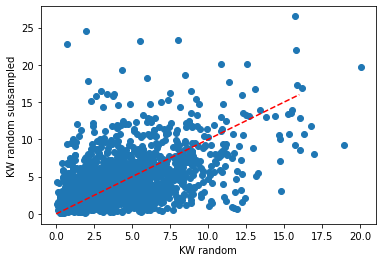

In [131]:
plt.scatter(tiklova_kw.KW_score, tiklova_random_kw.KW_score)
plt.plot([0, 16], [0, 16], 'r--')
plt.xlabel('KW random')
plt.ylabel('KW random subsampled')

Git2_5


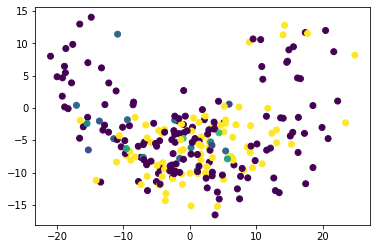

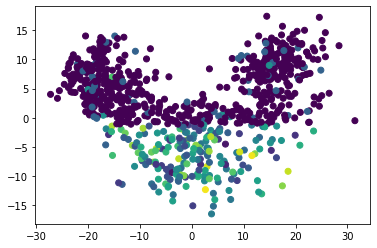

Eif4g1_5


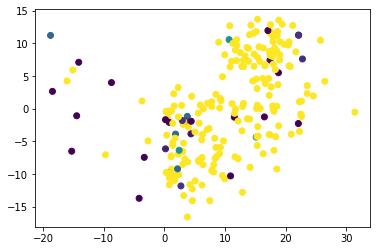

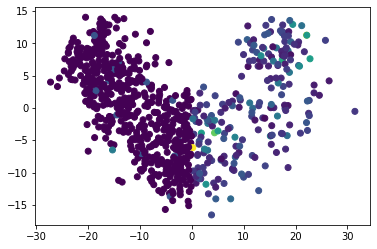

Tmem135_1


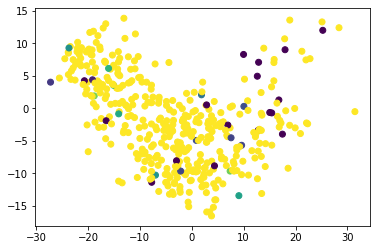

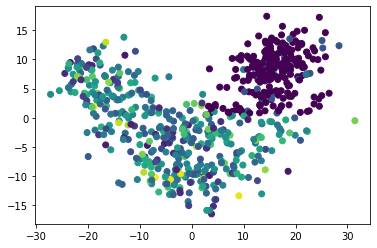

Cops4_5


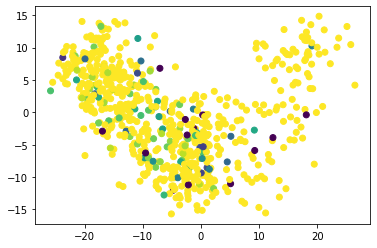

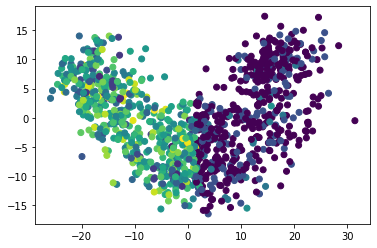

Pcmtd1_2


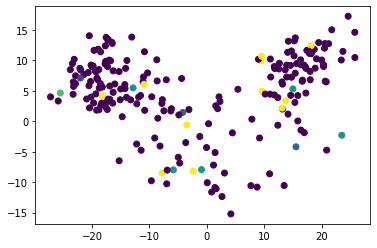

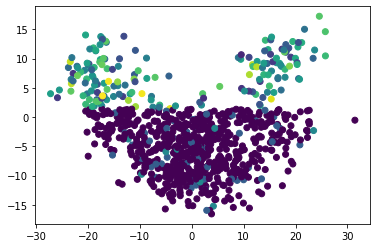

Nf2_7


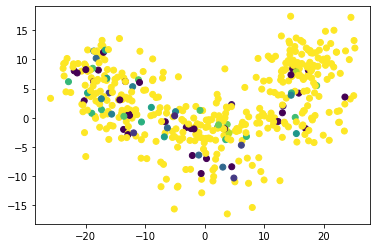

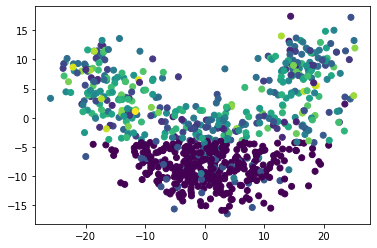

Ppp1r16a_5


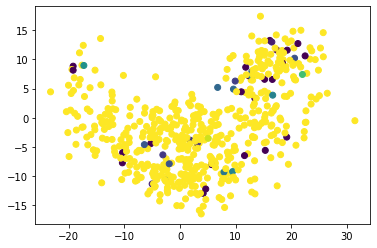

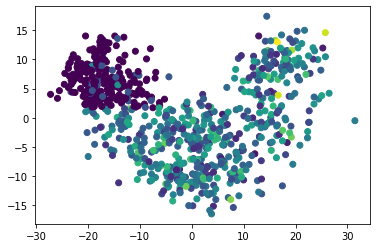

Ctnna2_2


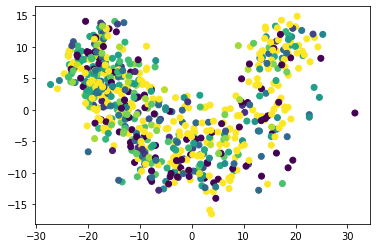

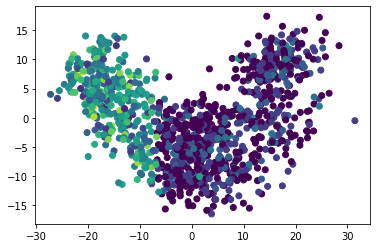

Chordc1_1


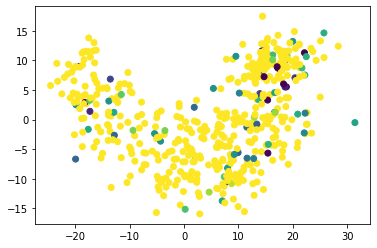

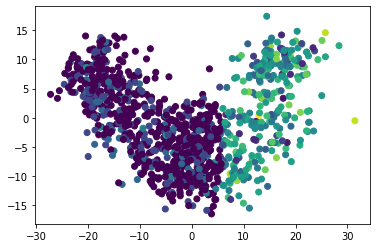

Ppp1r16a_2


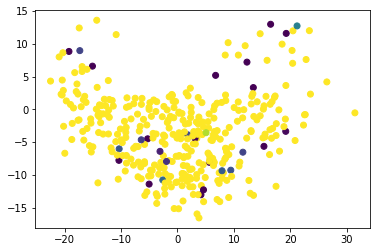

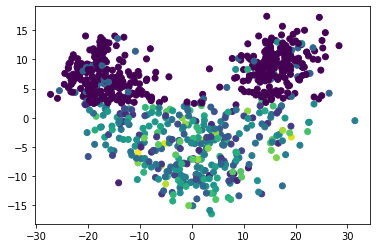

Tpra1_nmdSE_1


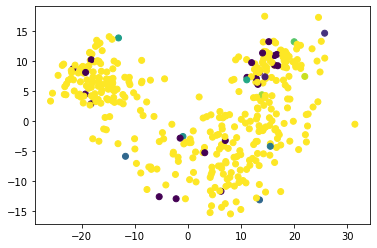

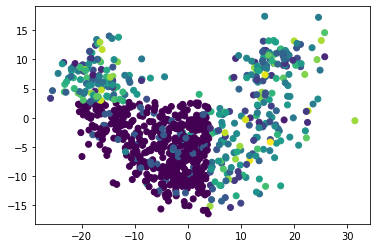

Celf4_2


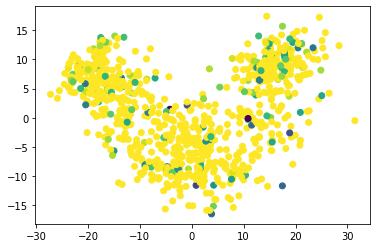

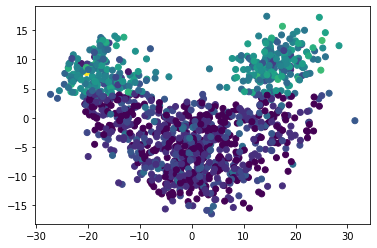

Setd3_3


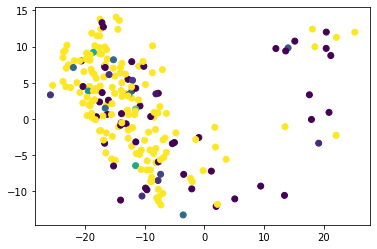

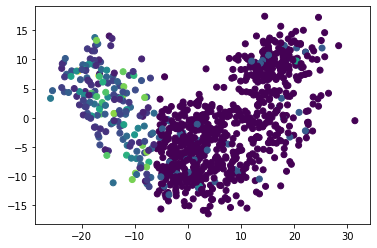

Git2_8


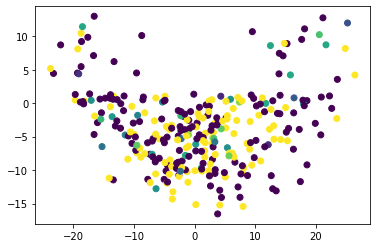

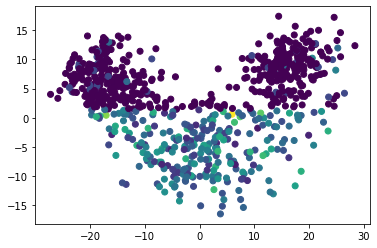

Arhgap12_3


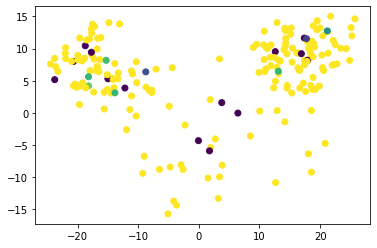

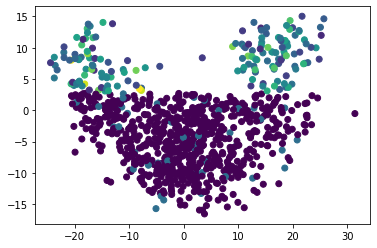

Hnrnph1_3


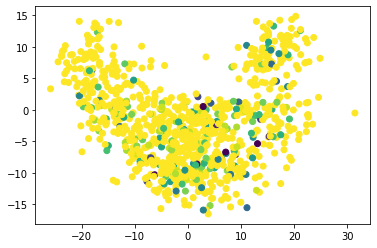

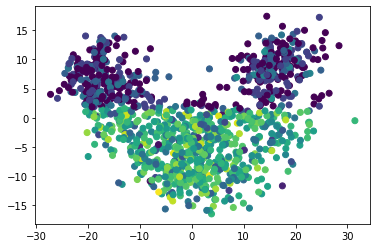

Isy1_3


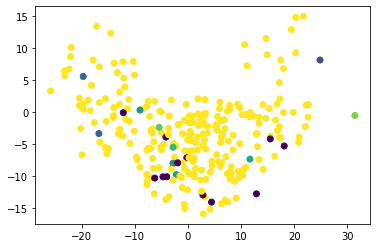

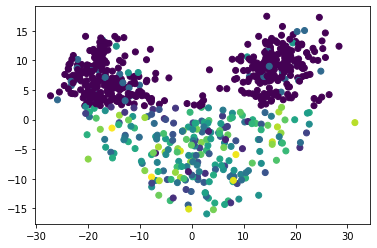

Ankrd16_nmdSE_1


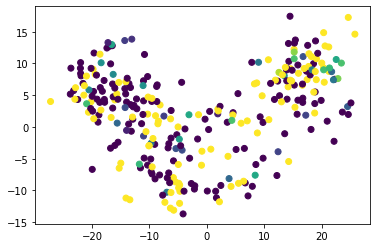

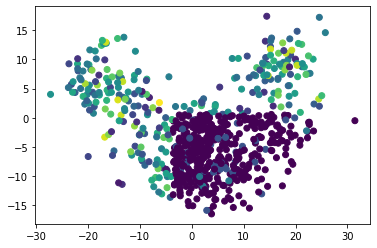

Snrnp70_3


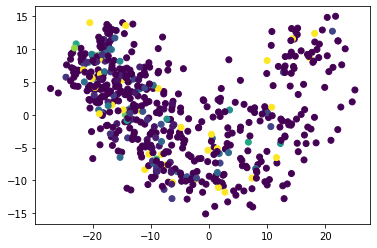

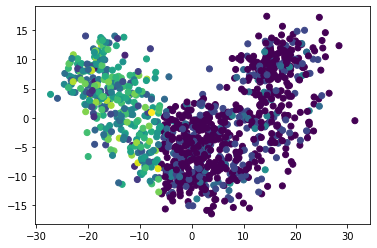

Hexdc_4


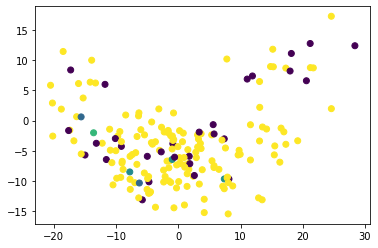

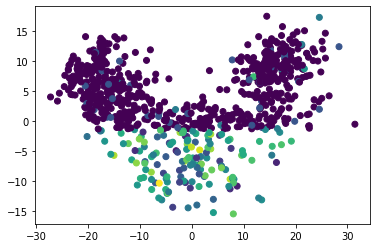

Srsf3_nmdSE_1


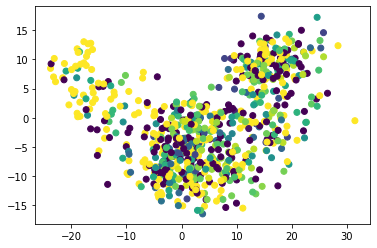

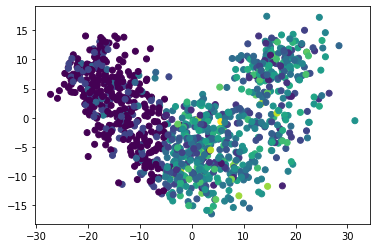

Meg3_9


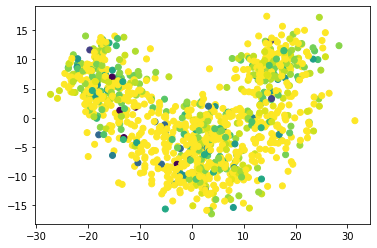

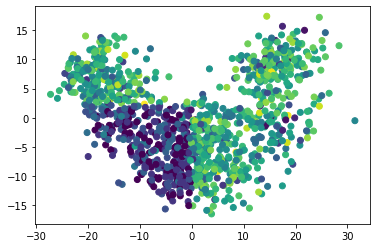

Erh_1


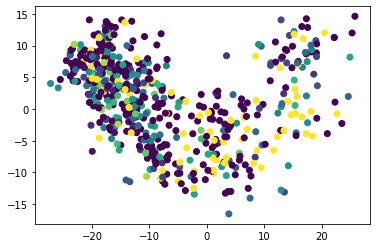

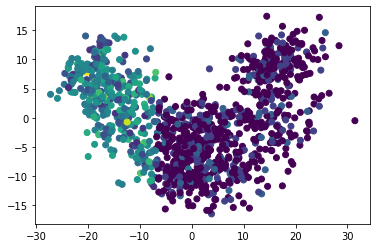

Gtf2i_11


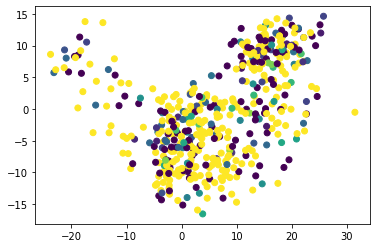

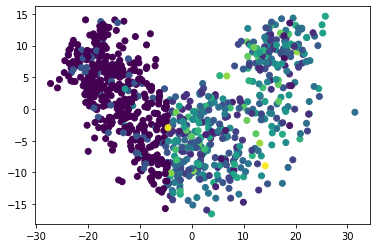

Erc2_8


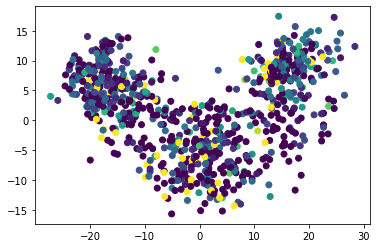

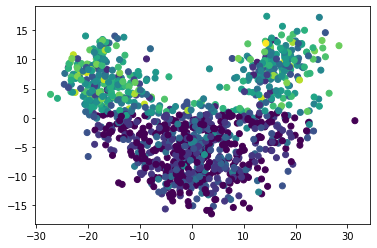

Mcf2l_5


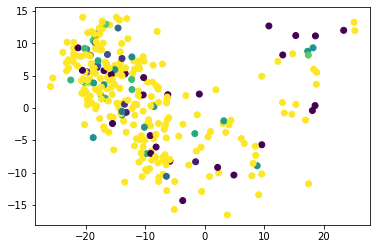

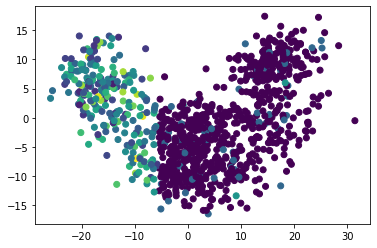

Agrn_7


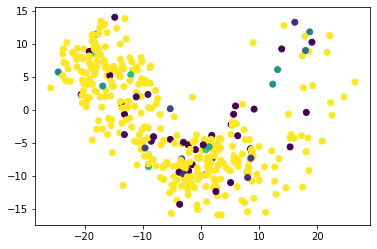

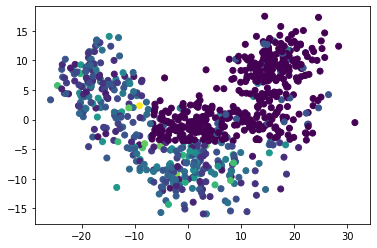

Hnrnpa2b1_2


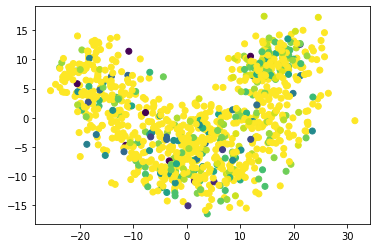

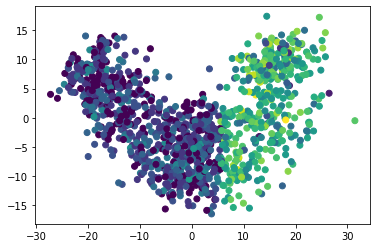

Ktn1_13


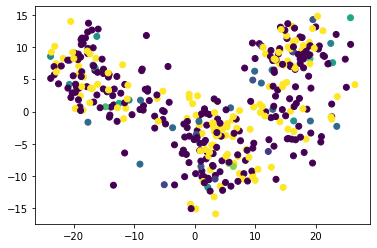

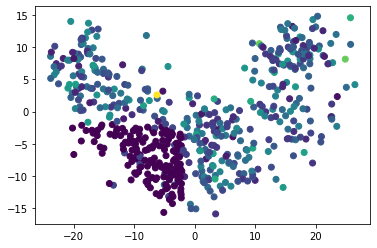

Ttc3_19


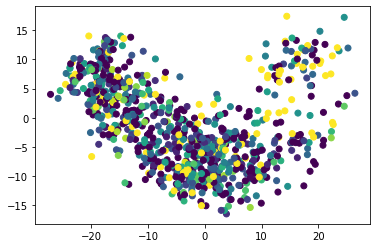

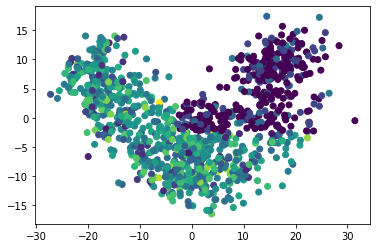

Fance_2


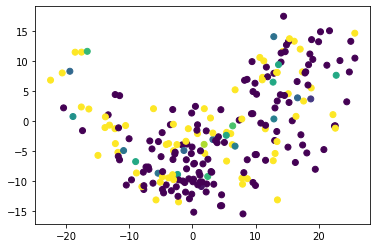

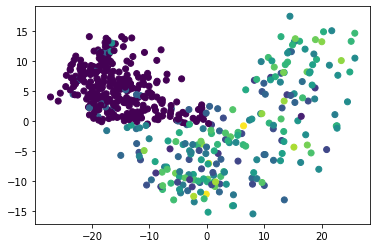

Ktn1_12


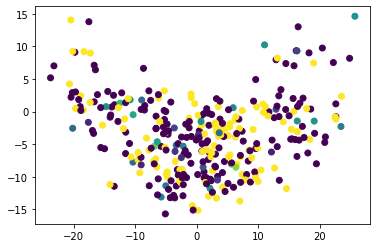

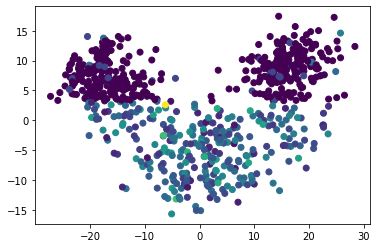

Ogdhl_4


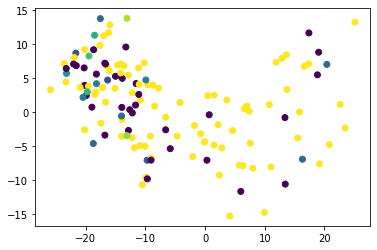

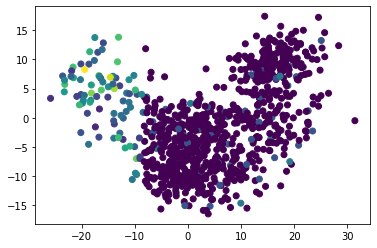

Aplp2_2


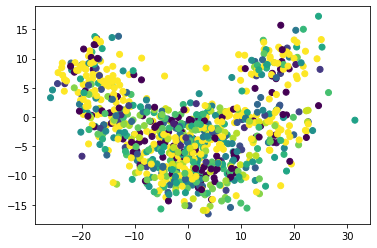

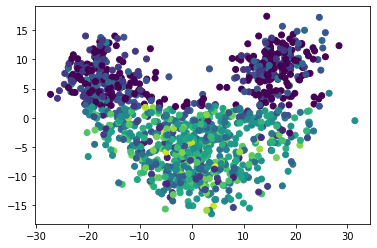

Tsg101_4


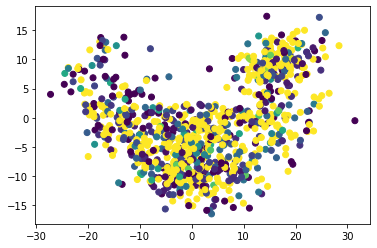

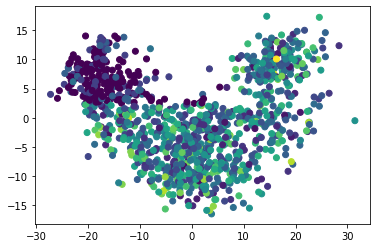

Cd200_1


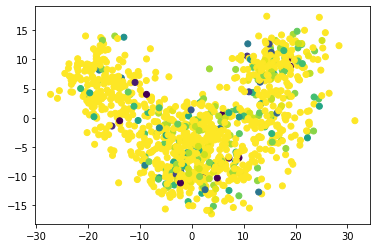

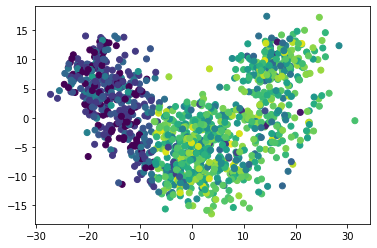

Bnip2_nmdSE_1


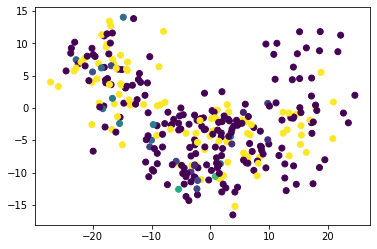

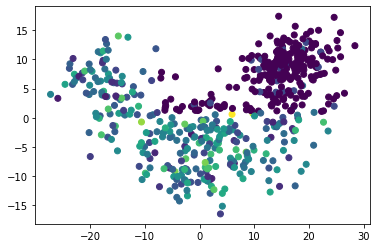

Calu_nmdSE_2


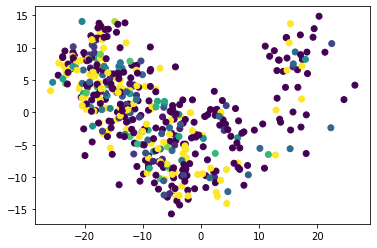

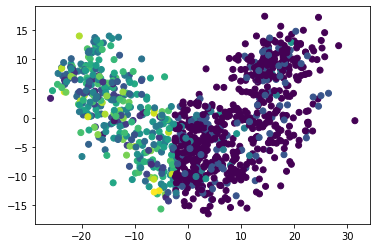

Gtf2a2_4


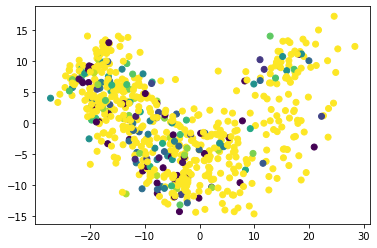

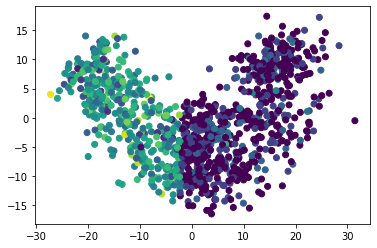

Rpn2_3


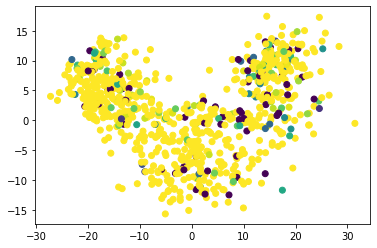

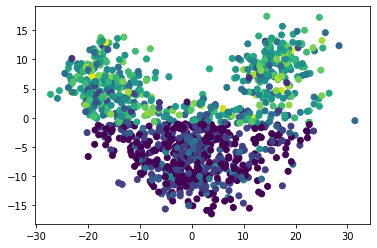

Klc1_2


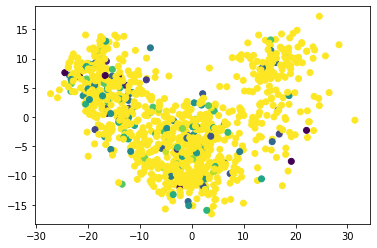

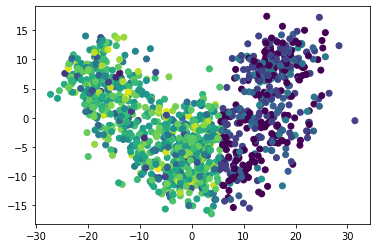

Ybx1_1


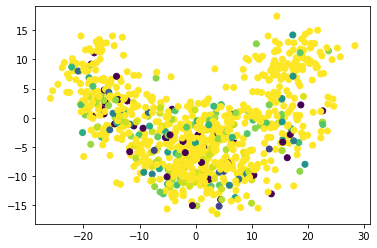

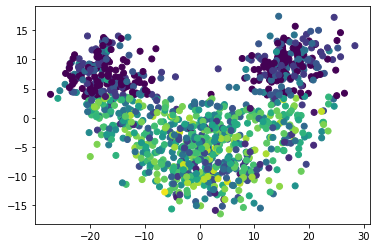

Cadm1_10


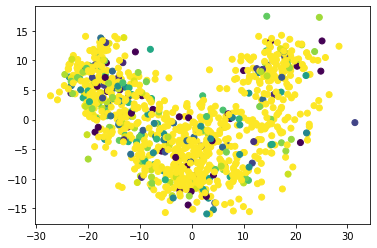

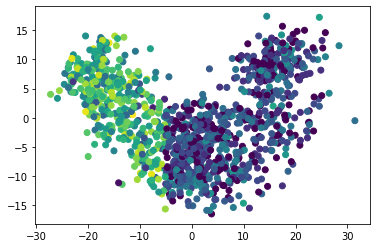

Dbn1_1


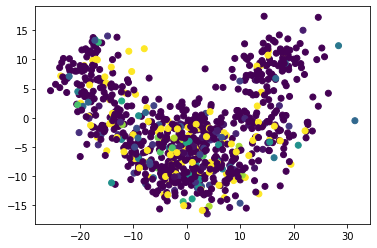

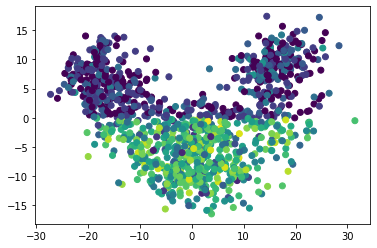

In [116]:
for exon in tiklova_random_kw.loc[tiklova_random_kw.pvals <= 0.01].index:
    print(exon)
    plt.scatter(tiklova_rd.PC_1, tiklova_rd.PC_2, c=random_psi_1.loc[exon])
    plt.show()
    plt.scatter(tiklova_rd.PC_1, tiklova_rd.PC_2, c=np.log10(random_mrna_1.loc[exon]+1))
    plt.show()

In [117]:
psix_random_sub = []
psix_random = []
for exon in tqdm(random_psi_1.index):
    psix_random_sub.append(calculate_exon_L(random_psi_1, W_tiklova, random_mrna_1, exon, k = 0, c = 0.1,approximate = 10))
    psix_random.append(calculate_exon_L(r_psi, W_tiklova, r_mrna, 
                     exon, k = 0, c = 0.1,approximate = 10))
    


  0%|          | 3/1988 [00:00<05:19,  6.22it/s]/mnt/lareaulab/cfbuenabadn/psix/utils/utils_functions.py:129: RuntimeWarning: invalid value encountered in true_divide
  obs_min: minimum % of cells in cluster that have an observation to run the test
  6%|▌         | 114/1988 [00:15<04:25,  7.07it/s]/mnt/lareaulab/cfbuenabadn/psix/utils/utils_functions.py:69: RuntimeWarning: overflow encountered in double_scalars
  int_exons = get_int_events(psi_table, psi_min, obs_min)
/mnt/lareaulab/cfbuenabadn/psix/utils/utils_functions.py:69: RuntimeWarning: invalid value encountered in double_scalars
  int_exons = get_int_events(psi_table, psi_min, obs_min)
100%|██████████| 1988/1988 [06:38<00:00,  4.99it/s]


Text(0, 0.5, 'Psix random subsampled')

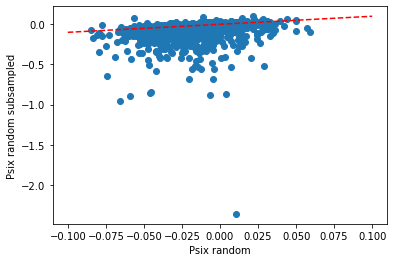

In [130]:
plt.scatter(psix_random, psix_random_sub)
plt.plot([-0.1, 0.1], [-0.1, 0.1], 'r--')
plt.xlabel('Psix random')
plt.ylabel('Psix random subsampled')

In [121]:
psix_df = pd.DataFrame()
psix_df['psix_random'] = psix_random
psix_df['psix_random_sub'] = psix_random_sub
psix_df.index = random_psi_1.index

In [124]:
(psix_df.psix_random_sub - psix_df.psix_random).sort_values()

Eif4g1_8    -2.370615
Prr14l_4    -0.890676
Odf2_12     -0.877089
Anks3_3     -0.874502
Clasp1_10   -0.831348
               ...   
Tmem175_1    0.065420
Exosc1_6     0.067668
Dnajc17_1    0.076204
Brd7_3       0.099756
Agtpbp1_6    0.138290
Length: 1988, dtype: float64

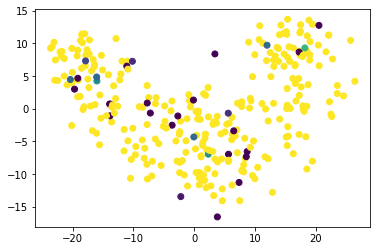

In [126]:
plt.scatter(tiklova_rd.PC_1, tiklova_rd.PC_2, c=tiklova_PSI.loc['Eif4g1_8', shuffled_cells])

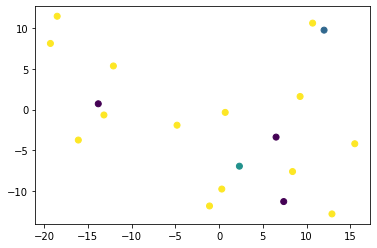

In [127]:
plt.scatter(tiklova_rd.PC_1, tiklova_rd.PC_2, c=random_psi_1.loc['Eif4g1_8'])

Text(0.5, 1.0, 'Score change pseudosimulations')

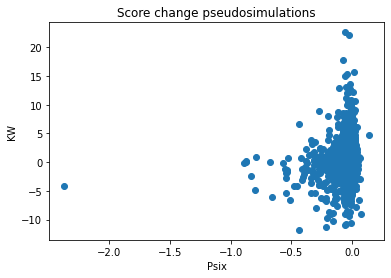

In [125]:
plt.scatter(np.array(psix_random_sub) - np.array(psix_random),
         tiklova_random_kw.KW_score - tiklova_kw.KW_score)
plt.xlabel('Psix')
plt.ylabel('KW')
plt.title('Score change pseudosimulations')

/mnt/lareaulab/cfbuenabadn/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/mnt/lareaulab/cfbuenabadn/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, 'random subsampled KW')

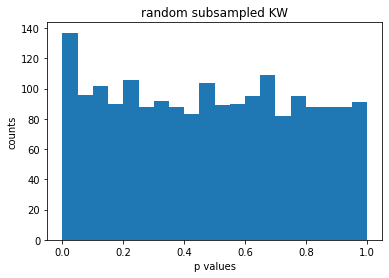

In [128]:
plt.hist(tiklova_random_kw.pvals, bins=20)
plt.xlabel('p values')
plt.ylabel('counts')
plt.title('random subsampled KW')

Text(0.5, 1.0, 'random KW')

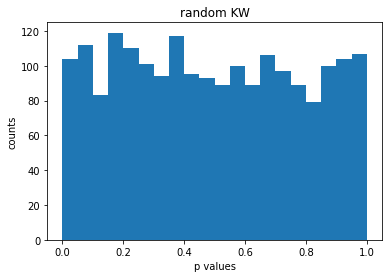

In [133]:
plt.hist(tiklova_kw.pvals, bins=20)
plt.xlabel('p values')
plt.ylabel('counts')
plt.title('random KW')

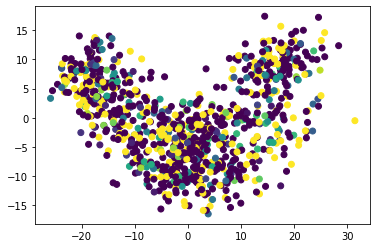

In [30]:
plt.scatter(tiklova_rd.PC_1, tiklova_rd.PC_2, c=tiklova_PSI.loc['Kif3a_1', shuffled_cells])

In [ ]:
random_psi_1, random_mrna_1 = make_test(tiklova_PSI.loc[tiklova_psix.index], 
                                        tiklova_mrna_event.loc[tiklova_psix.index], 
                                    tiklova_SJ_reads, tiklova_psix.index, tiklova_rd[['PC_1', 'PC_2']], seed=0)

  0%|          | 0/1988 [00:00<?, ?it/s]

selecting cells


 36%|███▌      | 706/1988 [12:48<26:02,  1.22s/it]

In [27]:
tecr_50 = downsample_exon(tiklova_SJ_reads, tiklova_mrna_event, 'Tecr_6', tiklova_PSI.columns, 
                           downsample_rate = 0.5)[0].loc['Tecr_6']

tecr_25 = downsample_exon(tiklova_SJ_reads, tiklova_mrna_event, 'Tecr_6', tiklova_PSI.columns, 
                           downsample_rate = 0.25)[0].loc['Tecr_6']

tecr_10 = downsample_exon(tiklova_SJ_reads, tiklova_mrna_event, 'Tecr_6', tiklova_PSI.columns, 
                           downsample_rate = 0.1)[0].loc['Tecr_6']

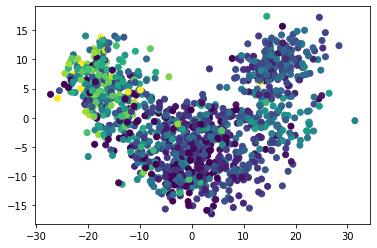

In [21]:
plt.scatter(tiklova_rd.PC_1, tiklova_rd.PC_2, c=tiklova_PSI.loc['Tecr_6'])

In [9]:
cadm1_50

SRR7408400  SRR7408401  SRR7408404  SRR7408413  SRR7408414  \
Cadm1_10         1.0         1.0         1.0         1.0         1.0   

          SRR7408418  SRR7408422  SRR7408424  SRR7408426  SRR7408427  ...  \
Cadm1_10         1.0         1.0         NaN         1.0         1.0  ...   

          SRR7410086  SRR7410088  SRR7410089  SRR7410090  SRR7410091  \
Cadm1_10         0.4         NaN         0.5         0.0    0.636364   

          SRR7410092  SRR7410093  SRR7410094  SRR7410096  SRR7410097  
Cadm1_10        0.75         1.0    0.357143    0.428571         0.0  

[1 rows x 1197 columns]

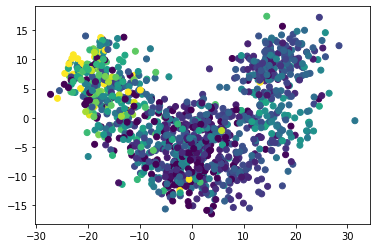

In [28]:
plt.scatter(tiklova_rd.PC_1, tiklova_rd.PC_2, c=tecr_50)

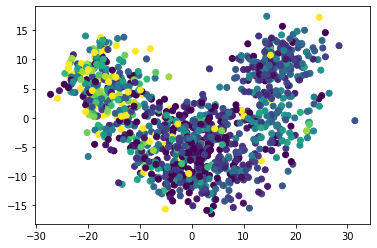

In [29]:
plt.scatter(tiklova_rd.PC_1, tiklova_rd.PC_2, c=tecr_25)

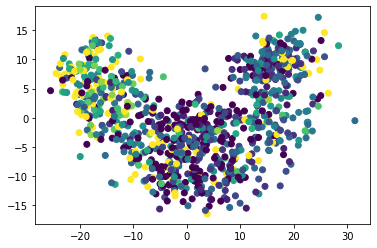

In [30]:
plt.scatter(tiklova_rd.PC_1, tiklova_rd.PC_2, c=tecr_10)

In [17]:
tiklova_psix.index[(tiklova_psix.L_score > 0.1) & (tiklova_psix.L_score < 0.25)]

Index(['Agrn_11', 'Clasp1_17', 'Eml1_3', 'Epb41_2', 'Map4_16', 'Abi2_2',
       'Alcam_1', 'Baz2b_4', 'C2cd5_2', 'Dync1li2_2',
       ...
       'Aplp2_2', 'Clk1_1', 'Nap1l4_18', 'Wsb1_nmdSE_1', 'Cadm1_2', 'Ldhb_1',
       'Resp18_1', 'Snhg11_nmdSE_1', 'Tecr_6', 'Cadm1_4'],
      dtype='object', length=155)